In [1]:
import numpy as np
import h5py
import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd 
import seaborn as sns
from typing import Iterable, List
from timeit import default_timer as timer
import scipy
import torch
import torch.nn as nn
from torch.nn import Transformer
from torch import Tensor
from sklearn.preprocessing import StandardScaler

In [2]:
#load in the data and name the different parts
filename = "gravity.h5"
hdf = h5py.File(filename, 'r')
print(list(hdf.keys()))
background=hdf['background']
bbh=hdf['binaryblackhole']
ccsn=hdf['ccsn']
glitch=hdf['glitch']

['background', 'binaryblackhole', 'ccsn', 'glitch']


In [3]:


# create a function that takes in an array of shape (2, 4096) and outputs a spectrogram of shape (2, 128 x 128) 
#using scipy.signal.spectrogram

dt = 0.001

def make_spectrogram (array):
    spec_in = scipy.signal.spectrogram(array, fs=1/dt, nperseg=175, noverlap=120, mode = 'magnitude')
    spec = spec_in[2]
    return spec


In [4]:
### Use function to create spectrograms for all data
### the input data has shape (2, 2048, 4096), and the output data should have shape (2, 2048, x, y) 
### where x and y are the spectrogram dimensions

def convert_data_to_spectrogram (data):
    spectrogram = np.zeros((2, 2048, 88, 72))
    for i in range(2048):
        spectrogram[:,i,:,:] = make_spectrogram(data[:,i,:])
    return spectrogram


In [5]:
#normalize the spectrogram by combining the x and y axes, then flattening it along the multplied 
#frequency times time colum of the array and normalizing using standard scaler, and finally reshaping it 
#back to the orginal size of (2, 2048, x, y)
def normalize_spectrogram (spectrogram):
    spectrogram=spectrogram.reshape(2,2048,6336)
    reshaped_spectrogram=np.swapaxes(spectrogram, 1,2)
    flattened_spectrogram=reshaped_spectrogram.reshape(-1,2048)
    scaler=StandardScaler()
    scaler.fit(flattened_spectrogram)
    normalized_spectrogram=scaler.transform(flattened_spectrogram)
    spectrogram=normalized_spectrogram.reshape(2,2048,88,72)
    
    return spectrogram

In [6]:
### Create spectrograms for all data

bbh=np.swapaxes(bbh, 0,1)
background=np.swapaxes(background, 0,1)
ccsn=np.swapaxes(ccsn, 0,1)
glitch=np.swapaxes(glitch, 0,1)

bbh_spectrogram = convert_data_to_spectrogram(bbh)
background_spectrogram = convert_data_to_spectrogram(background)
ccsn_spectrogram = convert_data_to_spectrogram(ccsn)
glitch_spectrogram = convert_data_to_spectrogram(glitch)

bbh_spectrogram=normalize_spectrogram(bbh_spectrogram)
background_spectrogram=normalize_spectrogram(background_spectrogram)
ccsn_spectrogram=normalize_spectrogram(ccsn_spectrogram)
glitch_spectrogram=normalize_spectrogram(glitch_spectrogram)

### convert above arrays to tensors of the following shape
### (2, 2048, 88, 72) -> (2048, 2, 88, 72) -- (samples, channels, x, y )

bbh_tensor = torch.from_numpy(bbh_spectrogram).permute(1,0,2,3)
background_tensor = torch.from_numpy(background_spectrogram).permute(1,0,2,3)
ccsn_tensor = torch.from_numpy(ccsn_spectrogram).permute(1,0,2,3)
glitch_tensor = torch.from_numpy(glitch_spectrogram).permute(1,0,2,3)

In [7]:
### randomly split data into training, validation, and test sets
#using an 80-16-4 split for training testing and validation

from sklearn.model_selection import train_test_split

bbh_train, bbh_test = train_test_split(bbh_tensor, test_size=0.2, random_state=42)
bbh_train, bbh_val = train_test_split(bbh_train, test_size=0.2, random_state=42)

background_train, background_test = train_test_split(background_tensor, test_size=0.2, random_state=42)
background_train, background_val = train_test_split(background_train, test_size=0.2, random_state=42)

ccsn_train, ccsn_test = train_test_split(ccsn_tensor, test_size=0.2, random_state=42)
ccsn_train, ccsn_val = train_test_split(ccsn_train, test_size=0.2, random_state=42)

glitch_train, glitch_test = train_test_split(glitch_tensor, test_size=0.2, random_state=42)
glitch_train, glitch_val = train_test_split(glitch_train, test_size=0.2, random_state=42)


### create labels for data
## 0 -> bbh
## 1 -> background
## 2 -> ccsn
## 3 -> glitch

bbh_train_labels = np.zeros(len(bbh_train))
bbh_val_labels = np.zeros(len(bbh_val))
bbh_test_labels = np.zeros(len(bbh_test))

background_train_labels = np.ones(len(background_train))
background_val_labels = np.ones(len(background_val))
background_test_labels = np.ones(len(background_test))

ccsn_train_labels = np.ones(len(ccsn_train))*2
ccsn_val_labels = np.ones(len(ccsn_val))*2
ccsn_test_labels = np.ones(len(ccsn_test))*2

glitch_train_labels = np.ones(len(glitch_train))*3
glitch_val_labels = np.ones(len(glitch_val))*3
glitch_test_labels = np.ones(len(glitch_test))*3


### concatenate data and labels

train_data = torch.cat((bbh_train, background_train, ccsn_train, glitch_train), 0)
train_labels = np.concatenate((bbh_train_labels, background_train_labels, ccsn_train_labels, glitch_train_labels), 0)

val_data = torch.cat((bbh_val, background_val, ccsn_val, glitch_val), 0)
val_labels = np.concatenate((bbh_val_labels, background_val_labels, ccsn_val_labels, glitch_val_labels), 0)

test_data = torch.cat((bbh_test, background_test, ccsn_test, glitch_test), 0)
test_labels = np.concatenate((bbh_test_labels, background_test_labels, ccsn_test_labels, glitch_test_labels), 0)


### shuffle data -- this is important for training

from sklearn.utils import shuffle

train_data, train_labels = shuffle(train_data, train_labels)
val_data, val_labels = shuffle(val_data, val_labels)
test_data, test_labels = shuffle(test_data, test_labels)


### create dataloaders -- this is what we will use to train the model

from torch.utils.data import TensorDataset, DataLoader

train_dataset = TensorDataset(train_data, torch.from_numpy(train_labels))
val_dataset = TensorDataset(val_data, torch.from_numpy(val_labels))
test_dataset = TensorDataset(test_data, torch.from_numpy(test_labels))

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [8]:
### print shapes of training, validation, and test sets

print(bbh_train.shape)
print(bbh_val.shape)
print(bbh_test.shape)

torch.Size([1310, 2, 88, 72])
torch.Size([328, 2, 88, 72])
torch.Size([410, 2, 88, 72])


In [9]:
### create a CNN network to train on the data

import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        
        #use a cnn with a first layer of 32 features followed by relu and pooling, and another layer with 64 features
        #followed again by relu and pooling
        self.cnn=nn.Sequential(
                    nn.Conv2d(2,32,3,padding=1), nn.ReLU(), 
                    nn.MaxPool2d(2,2), nn.Conv2d(32,64,3,padding=1),
                    nn.ReLU(), nn.MaxPool2d(2,2))
        
        #lstm of the size of the convolutional layer to 128 features
        self.lstm = nn.LSTM(64 * 22 * 18, 128, batch_first=True)

        # linearly map the output of the lstm to 100
        # features before the final output layer
        self.fc1 = nn.Linear(128, 100)

        # linearly map 100 features to 32 features
        self.fc2 = nn.Linear(100, 32)
        
        #linearly map 32 features to four features
        self.fc3=nn.Linear(32,4)

        # dropout layer with p=0.5
        self.dropout = nn.Dropout(0.5)
        

    def forward(self, x):

        batch_size = x.size(0)
        
        features = self.cnn(x)
        
        features = features.view(batch_size, -1, 64 * 22 * 18)
        
        _, (hidden_state, _) = self.lstm(features)
        
        hidden_state = hidden_state.squeeze(0)
        
        x = self.fc1(hidden_state)
        
        x=self.dropout(x)
        
        x=self.fc2(x)
        
        x=self.dropout(x)
        
        x=self.fc3(x)

        return x

In [10]:
epochs = 30
learning_rate = 0.001

### define loss function and optimizer

model = Net()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

model

Net(
  (cnn): Sequential(
    (0): Conv2d(2, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (lstm): LSTM(25344, 128, batch_first=True)
  (fc1): Linear(in_features=128, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=4, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [11]:
train_loss_list = []
validation_accuracy_list = np.zeros((epochs,))

In [12]:
for epoch in range(epochs):

    train_loss = 0.0
    validation_accuracy = 0.0

    model.train()
    
    for data, labels in train_dataloader:

        optimizer.zero_grad()
        
        #use teacher forcing with a decreasing probablity as the epochs go on 
        for i in range (1,31):
            teacher_forcing_ratio=0.3+0.05*i
            use_teacher_forcing = True if np.random.random() < teacher_forcing_ratio else False

        output = model(data.float())

        loss = criterion(output, labels.long())
        loss.backward()
        optimizer.step()

        train_loss += loss.item()*data.size(0)

    model.eval()

    for data, labels in val_dataloader:

        output = model(data.float())

        _, preds = torch.max(output, 1)

        validation_accuracy += torch.sum(preds == labels.data)

    train_loss = train_loss/len(train_dataloader.dataset)
    validation_accuracy = validation_accuracy.double()/len(val_dataloader.dataset)

    train_loss_list.append(train_loss)
    validation_accuracy_list[epoch] = validation_accuracy

    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Accuracy: {:.6f}'.format(epoch+1, train_loss, validation_accuracy))

Epoch: 1 	Training Loss: 1.124952 	Validation Accuracy: 0.480183
Epoch: 2 	Training Loss: 0.829020 	Validation Accuracy: 0.532774
Epoch: 3 	Training Loss: 0.854057 	Validation Accuracy: 0.477134
Epoch: 4 	Training Loss: 0.804728 	Validation Accuracy: 0.705030
Epoch: 5 	Training Loss: 0.716854 	Validation Accuracy: 0.755335
Epoch: 6 	Training Loss: 0.645089 	Validation Accuracy: 0.587652
Epoch: 7 	Training Loss: 0.706216 	Validation Accuracy: 0.666921
Epoch: 8 	Training Loss: 0.570306 	Validation Accuracy: 0.784299
Epoch: 9 	Training Loss: 0.764145 	Validation Accuracy: 0.701220
Epoch: 10 	Training Loss: 0.525975 	Validation Accuracy: 0.736280
Epoch: 11 	Training Loss: 0.497399 	Validation Accuracy: 0.893293
Epoch: 12 	Training Loss: 0.359397 	Validation Accuracy: 0.925305
Epoch: 13 	Training Loss: 0.393432 	Validation Accuracy: 0.887195
Epoch: 14 	Training Loss: 0.410890 	Validation Accuracy: 0.765244
Epoch: 15 	Training Loss: 0.228325 	Validation Accuracy: 0.855945
Epoch: 16 	Training

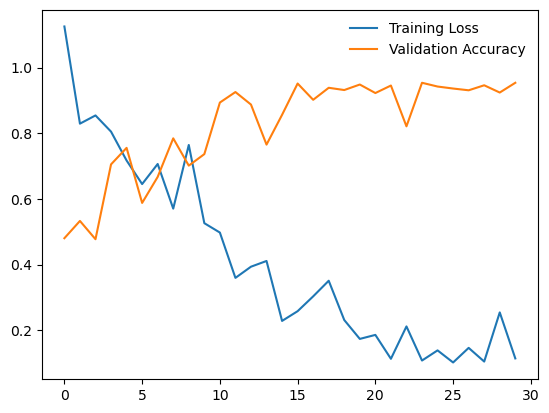

In [13]:
plt.plot(train_loss_list, label='Training Loss')
plt.plot(validation_accuracy_list, label='Validation Accuracy')
plt.legend(frameon=False)
plt.show()

In [14]:
test_accuracy = 0.0

model.eval()

for data, labels in test_dataloader:
    
        output = model(data.float())
    
        _, preds = torch.max(output, 1)
    
        test_accuracy += torch.sum(preds == labels.data)

test_accuracy = test_accuracy.double()/len(test_dataloader.dataset)

print('Test Accuracy: {:.6f}'.format(test_accuracy))

Test Accuracy: 0.953049


Correctly identified sample
True label: 3.0
Predicted label: 3



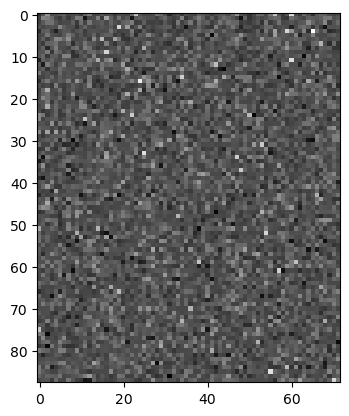

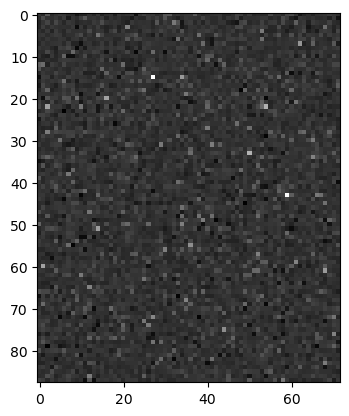

Correctly identified sample
True label: 1.0
Predicted label: 1



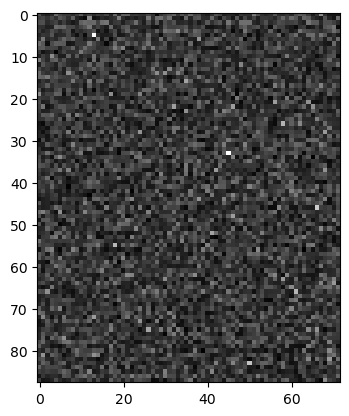

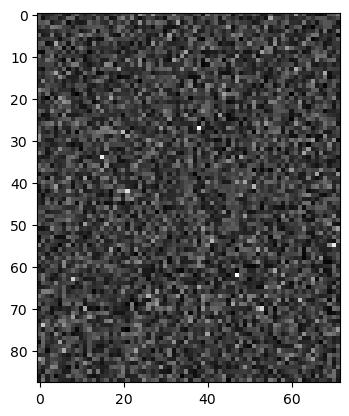

Correctly identified sample
True label: 3.0
Predicted label: 3



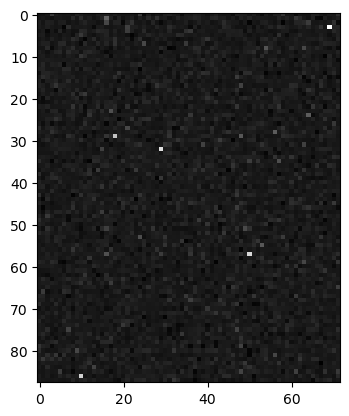

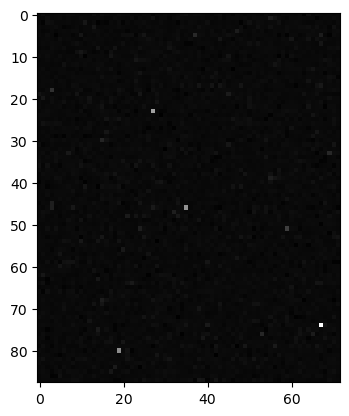

Correctly identified sample
True label: 2.0
Predicted label: 2



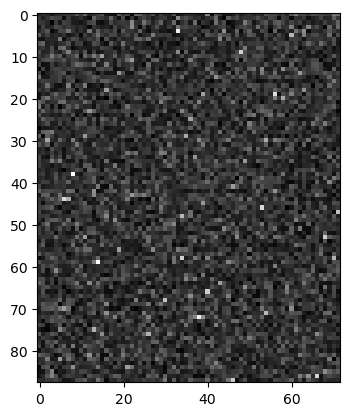

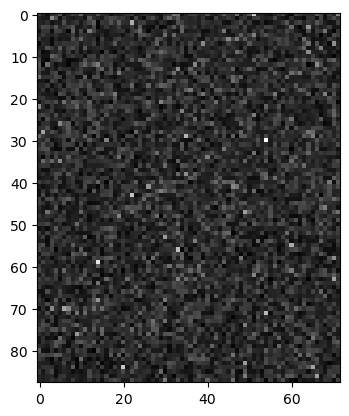

Correctly identified sample
True label: 0.0
Predicted label: 0



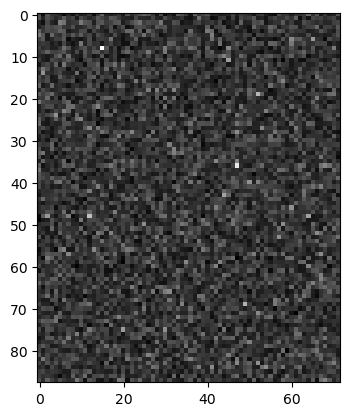

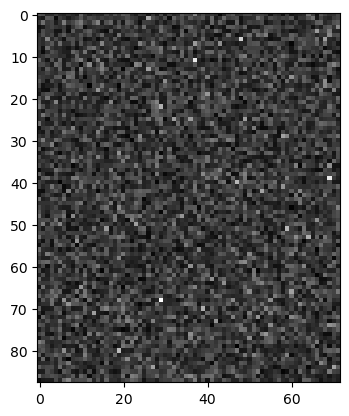

In [15]:
### show some correctly identified samples and some incorrectly identified samples, along with their labels 
## and the model's predicted labels

model.eval()

for data, labels in test_dataloader:

    output = model(data.float())

    _, preds = torch.max(output, 1)

    for i in range(5):

        if preds[i] == labels.data[i]:
            print('Correctly identified sample')
        else:
            print('Incorrectly identified sample')

        print('True label: {}'.format(labels.data[i]))
        print('Predicted label: {}'.format(preds[i]))
        print('')

        plt.imshow(data[i,0,:,:], cmap='gray')
        plt.show()

        plt.imshow(data[i,1,:,:], cmap='gray')
        plt.show()

        if i == 10:
            break

    break

In [16]:
#find the accuracy per class
num_classes=4
class_correct = [0] * num_classes
class_total = [0] * num_classes

with torch.no_grad():
    for data, labels in test_dataloader:
        output = model(data.float())
        _, preds = torch.max(output, 1)
        
        for i in range(len(labels)):
            label = int(labels[i].item())
            prediction = preds[i].item()
        
            
            if prediction == label:
                class_correct[label] += 1
            class_total[label] += 1

accuracy_per_class = [class_correct[i] / class_total[i] for i in range(num_classes)]

print("Class-wise accuracy:")
for i in range(num_classes):
    print(f"Class {i}: {accuracy_per_class[i]}")

Class-wise accuracy:
Class 0: 0.9512195121951219
Class 1: 0.9219512195121952
Class 2: 0.9390243902439024
Class 3: 1.0
